# Imports

In [1]:
import glob
import os
import random

import pandas as pd
import torch
from Bio.PDB.Polypeptide import index_to_one
from torch.utils.data import DataLoader, Dataset

from cavity_model import CavityModel, ResidueEnvironment, ResidueEnvironmentsDataset
from helpers import (
    _populate_dfs_with_nlls_and_nlfs,
    _populate_dfs_with_resenvs,
    _train_loop,
    _train_val_split,
)
from visualization import scatter_pred_vs_true

%load_ext nb_black

<IPython.core.display.Javascript object>

# Cavity Model

Download and process Cavity Model data

In [2]:
# # Run shell script that takes a .txt file with PDBIDs as input.
# !./get_and_parse_pdbs_for_cavity_model.sh data/pdbids_010.txt

<IPython.core.display.Javascript object>

Global variables for Cavity Model Training

In [3]:
DEVICE = "cuda"  # "cpu" or "cuda"
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 100
SHUFFLE_PDBS = True
LEARNING_RATE = 3e-4
EPOCHS = 10
PATIENCE_CUTOFF = 1
EPS = 1e-9

<IPython.core.display.Javascript object>

Load Parsed PDBs and perform train/val split

In [4]:
parsed_pdb_filenames = sorted(glob.glob("data/pdbs/parsed/*coord*"))
if SHUFFLE_PDBS:
    random.shuffle(parsed_pdb_filenames)
dataloader_train, dataset_train, dataloader_val, dataset_val = _train_val_split(
    parsed_pdb_filenames, TRAIN_VAL_SPLIT, DEVICE, BATCH_SIZE
)

Training data set includes 8 pdbs with 4355 environments.
Validation data set includes 2 pdbs with 903 environments.


<IPython.core.display.Javascript object>

Train the cavity model

In [5]:
# Define model
cavity_model_net = CavityModel(DEVICE).to(DEVICE)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cavity_model_net.parameters(), lr=LEARNING_RATE)

# Create directory for model files
models_dirpath = "cavity_models/"
if not os.path.exists(models_dirpath):
    os.mkdir(models_dirpath)

# Train loop
best_model_path = _train_loop(
    dataloader_train,
    dataloader_val,
    cavity_model_net,
    loss_function,
    optimizer,
    EPOCHS,
    PATIENCE_CUTOFF,
)

Epoch  0. Train loss: 2.562. Train Acc: 0.28. Val loss: 3.193. Val Acc 0.07
Epoch  1. Train loss: 1.406. Train Acc: 0.71. Val loss: 2.558. Val Acc 0.23
Epoch  2. Train loss: 0.834. Train Acc: 0.91. Val loss: 2.527. Val Acc 0.24
Epoch  3. Train loss: 0.446. Train Acc: 0.98. Val loss: 2.619. Val Acc 0.22
Epoch  4. Train loss: 0.229. Train Acc: 1.00. Val loss: 2.632. Val Acc 0.23
Early stopping activated.
Best epoch idx: 2 with validation loss: 2.527 and model_path: cavity_models/model_epoch_02.pt


<IPython.core.display.Javascript object>

# ddG Prediction

Parse PDBs for DMS, Guerois and Protein G data sets

In [6]:
# # Parse PDBs for which we have ddG data
# !./get_and_parse_pdbs_for_dowstream_task.sh

<IPython.core.display.Javascript object>

Make dict for residue environments for easy look up

In [7]:
# Create temporary residue environment datasets as dicts to more easily match ddG data
parsed_pdbs_wildcards = {
    "dms": "data/data_dms/pdbs_parsed/*coord*",
    "protein_g": "data/data_protein_g/pdbs_parsed/*coord*",
    "guerois": "data/data_guerois/pdbs_parsed/*coord*",
    "symmetric": "data/data_symmetric/pdbs_parsed/*coord*",
}

resenv_datasets_look_up = {}
for dataset_key, pdbs_wildcard in parsed_pdbs_wildcards.items():
    parsed_pdb_filenames = sorted(glob.glob(pdbs_wildcard))
    dataset = ResidueEnvironmentsDataset(parsed_pdb_filenames, transformer=None)
    dataset_look_up = {}
    for resenv in dataset:
        key = (
            f"{resenv.pdb_id}{resenv.chain_id}_{resenv.pdb_residue_number}"
            f"{index_to_one(resenv.restype_index)}"
        )
        dataset_look_up[key] = resenv
    resenv_datasets_look_up[dataset_key] = dataset_look_up

<IPython.core.display.Javascript object>

Load ddG data to dataframe

In [8]:
from collections import OrderedDict

ddg_data_dict = OrderedDict()
ddg_data_dict = {
    "dms": pd.read_csv("data/data_dms/ddgs_parsed.csv"),
    "protein_g": pd.read_csv("data/data_protein_g/ddgs_parsed.csv"),
    "guerois": pd.read_csv("data/data_guerois/ddgs_parsed.csv"),
    "symmetric_direct": pd.read_csv("data/data_symmetric/ddgs_parsed_direct.csv"),
    "symmetric_inverse": pd.read_csv("data/data_symmetric/ddgs_parsed_inverse.csv"),
}

<IPython.core.display.Javascript object>

Populate dataframes with wt ResidueEnvironment objects and wt and mt restype indices

In [9]:
_populate_dfs_with_resenvs(ddg_data_dict, resenv_datasets_look_up)

Dropping data points where residue is not defined in structure or due to missing parsed pdb file
dropped 1187 / 8096 data points from dataset dms
dropped    0 /  907 data points from dataset protein_g
dropped    0 /  911 data points from dataset guerois
dropped    0 /  342 data points from dataset symmetric_direct
dropped    1 /  342 data points from dataset symmetric_inverse


<IPython.core.display.Javascript object>

Populate dataframes with predicted NLLs and isolated WT and MT predicted NLLs as well as NLFs

In [10]:
# Load best performing cavity model from previos training
cavity_model_infer_net = CavityModel(DEVICE).to(DEVICE)
cavity_model_infer_net.load_state_dict(torch.load(best_model_path))
cavity_model_infer_net.eval()

_populate_dfs_with_nlls_and_nlfs(
    ddg_data_dict, cavity_model_infer_net, DEVICE, BATCH_SIZE, EPS, display_n_rows=2
)

dms


,pdbid,chainid,variant,ddg,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
120,1D5R,A,R14A,-0.087552,<ResidueEnvironment with 141 atoms. pdb_id: 1D...,14,0,"[3.761355, 3.8874278, 2.0133736, 3.2964132, 4....",3.139378,3.761355,3.035567,2.483982,1.173562
121,1D5R,A,R14D,-0.142873,<ResidueEnvironment with 141 atoms. pdb_id: 1D...,14,2,"[3.761355, 3.8874278, 2.0133736, 3.2964132, 4....",3.139378,2.013374,3.035567,2.824680,-0.915117


protein_g


,pdbid,chainid,variant,ddg,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
0,1PGA,A,M1A,-0.1407,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,0,"[4.8995667, 2.7171252, 3.0366936, 2.2134588, 2...",3.708021,4.899567,3.785957,2.483982,2.493520
1,1PGA,A,M1D,-0.3795,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,2,"[4.8995667, 2.7171252, 3.0366936, 2.2134588, 2...",3.708021,3.036694,3.785957,2.824680,0.289949


guerois


,pdbid,chainid,variant,ddg,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
0,171L,A,A45E,0.01,<ResidueEnvironment with 189 atoms. pdb_id: 17...,0,3,"[4.3328247, 3.21393, 1.7516489, 2.6335964, 2.6...",4.332825,2.633596,2.483982,2.712832,-1.928078
1,1A2P,A,Y103F,0.00,<ResidueEnvironment with 211 atoms. pdb_id: 1A...,19,4,"[2.1669757, 2.861004, 3.7422621, 5.1602373, 2....",2.647622,2.669165,3.311580,3.207937,0.125185


symmetric_direct


,pdbid,chainid,variant,ddg,merge_column,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
0,1AMQ,A,C191Y,2.3,index_1,<ResidueEnvironment with 278 atoms. pdb_id: 1A...,1,19,"[4.2539964, 3.4823747, 2.8891742, 2.4216547, 3...",3.482375,2.408788,4.33514,3.311580,-0.050026
1,1AMQ,A,C191F,1.6,index_2,<ResidueEnvironment with 278 atoms. pdb_id: 1A...,1,4,"[4.2539964, 3.4823747, 2.8891742, 2.4216547, 3...",3.482375,3.296098,4.33514,3.207937,0.940926


symmetric_inverse


,pdbid,chainid,variant,ddg,merge_column,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
1,1QIS,A,F191C,-1.6,index_2,<ResidueEnvironment with 275 atoms. pdb_id: 1Q...,4,1,"[2.8451436, 2.2418942, 4.166224, 3.5480084, 2....",2.856829,2.241894,3.207937,4.33514,-1.742138
2,1QIT,A,W191C,-3.9,index_3,<ResidueEnvironment with 273 atoms. pdb_id: 1Q...,18,1,"[3.2382548, 2.0971, 3.281807, 3.5571334, 2.379...",2.235432,2.097100,4.250501,4.33514,-0.222970


<IPython.core.display.Javascript object>

### Results without downstream model

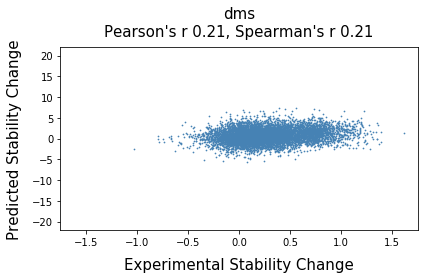

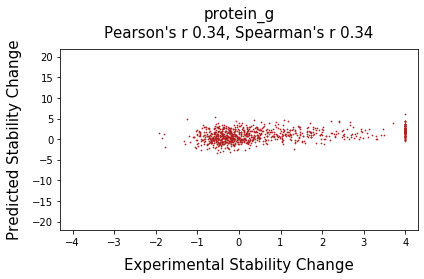

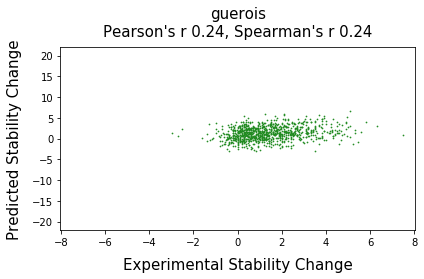

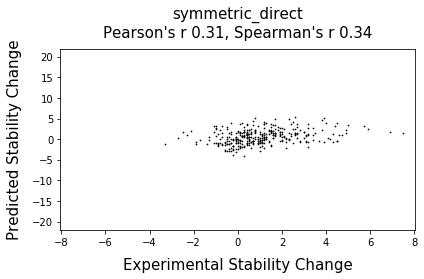

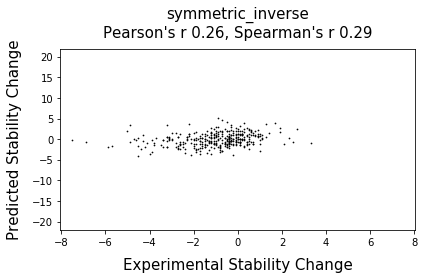

<IPython.core.display.Javascript object>

In [11]:
colors = ["steelblue", "firebrick", "forestgreen", "black", "black"]
for color, data_key in zip(colors, ddg_data_dict.keys()):
    fig, ax = scatter_pred_vs_true(
        ddg_data_dict[data_key]["ddg"],
        ddg_data_dict[data_key]["ddg_pred_no_ds"],
        color=color,
        title=data_key,
    )

Merge direct and inverse dfs

In [12]:
# Rename columns so they specify if it is the direct or inverse direction
symmetric_direct_df = ddg_data_dict["symmetric_direct"]
symmetric_direct_df.columns = [
    name + "_dir" if "_dir" not in name else name
    for name in symmetric_direct_df.columns
]
symmetric_inverse_df = ddg_data_dict["symmetric_inverse"]
symmetric_inverse_df.columns = [
    name + "_inv" if "_inv" not in name else name
    for name in symmetric_inverse_df.columns
]

# Inner merge both dataframes
ddg_data_dict["symmetric_both"] = pd.merge(
    symmetric_direct_df,
    symmetric_inverse_df,
    how="inner",
    left_on="merge_column_dir",
    right_on="merge_column_inv",
)

<IPython.core.display.Javascript object>

Make prediction based on both directions

In [13]:
symmetric_both_df = ddg_data_dict["symmetric_both"]
symmetric_both_df["ddg_pred_no_ds_both_dir"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_no_ds_dir"] - row["ddg_pred_no_ds_inv"]), axis=1
)
symmetric_both_df["ddg_pred_no_ds_both_inv"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_no_ds_inv"] - row["ddg_pred_no_ds_dir"]), axis=1
)

<IPython.core.display.Javascript object>

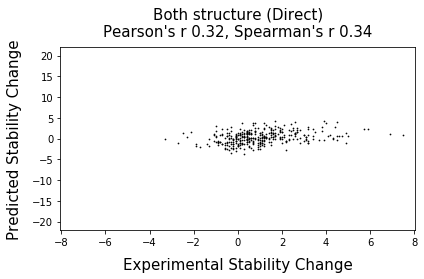

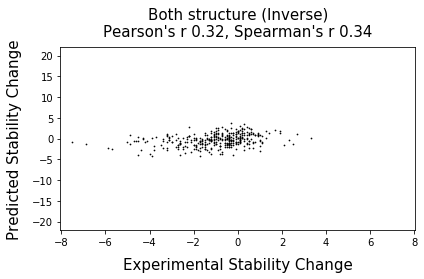

<IPython.core.display.Javascript object>

In [14]:
# Plot prediction for ddg direct using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_dir"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_dir"],
    color="black",
    title="Both structure (Direct)",
)

# Plot prediction for ddg inverse using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_inv"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_inv"],
    color="black",
    title="Both structure (Inverse)",
)

# Downstream model